In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, roc_auc_score

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id': '1tg7uu8GvstsNh8tMo5xq0kyCz9PHgB9s'})
downloaded.GetContentFile('train_identity.csv')

downloaded = drive.CreateFile({'id': '1fFEYaig3cowq6K_TkJAt4DpMW3zVxekR'})
downloaded.GetContentFile('train_transaction.csv')

downloaded = drive.CreateFile({'id': '1zoei-WhFKXoniiOkTbxhzPWW1htwQMlI'})
downloaded.GetContentFile('model_backup_xgb')

In [ ]:
identity = pd.read_csv('train_identity.csv', encoding='latin-1')
transaction = pd.read_csv('train_transaction.csv', encoding='latin-1')
join = transaction.merge(identity, left_on= 'TransactionID', right_on='TransactionID',how='outer')

identity = None
transaction = None

In [ ]:
join.drop(['TransactionID'], axis = 1, inplace=True)

Para mi set de validación me voy a quedar con los que sean después de los 140 dias (aprox el 20%), osea **TransactionDT >= 140*86400 = 12.096.000**

In [ ]:
train = join[join['TransactionDT'] < 12096000]
validation = join[join['TransactionDT'] >= 12096000]

join = None

**NaN**

Si son de features numericos: pasaran a ser el promedio de la columna.

Si son de features no numericos: pasaran a ser el valor 'Desconocido' (pasa a ser una categoría del feature)

In [ ]:
aux = train.select_dtypes(include = {'float64', 'int64'}).columns.values.tolist()
aux2 = {}
for elem in aux:
  aux2[elem] = train[elem].mean()

train.fillna(aux2, inplace=True)
validation.fillna(aux2, inplace=True)
# Hasta acá solo quedaron en NaN los de variables no numericas
train.fillna('Desconocido', inplace=True)
validation.fillna('Desconocido', inplace=True)

Algunos features tienen bastantes categorías, para ahicarlo un poco me quedo con el top 10 y el resto serán categoría "Otros"

In [ ]:
device_info = train['DeviceInfo'].value_counts().to_frame().head(10).index
train.loc[~train['DeviceInfo'].isin(device_info), 'DeviceInfo'] = 'Otros'
validation.loc[~validation['DeviceInfo'].isin(device_info), 'DeviceInfo'] = 'Otros'

id_31 = train['id_31'].value_counts().to_frame().head(10).index
train.loc[~train['id_31'].isin(id_31), 'id_31'] = 'Otros'
validation.loc[~validation['id_31'].isin(id_31), 'id_31'] = 'Otros'

id_33 = train['id_33'].value_counts().to_frame().head(10).index
train.loc[~train['id_33'].isin(id_33), 'id_33'] = 'Otros'
validation.loc[~validation['id_33'].isin(id_33), 'id_33'] = 'Otros'

**One Hot Encoder:**

In [ ]:
ohe = pd.get_dummies(train['ProductCD'], drop_first = False, dummy_na = True)
ohe.head()

,C,H,R,S,W,NaN
0,0,0,0,0,1,0
1,0,0,0,0,1,0
2,0,0,0,0,1,0
3,0,0,0,0,1,0
4,0,1,0,0,0,0


In [ ]:
train.drop(['ProductCD'], axis = 1, inplace = True)
train = pd.concat([train, ohe], axis = 1)

In [ ]:
ohe2 = pd.get_dummies(validation['ProductCD'], drop_first = False, dummy_na = True)
validation.drop(['ProductCD'], axis = 1, inplace = True)
validation = pd.concat([validation, ohe2], axis = 1)

**Count Vectorizer**

In [ ]:
cv = CountVectorizer()
voc_train = cv.fit_transform(train['id_30'].tolist())
voc_validation = cv.transform(validation['id_30'].tolist())
vocabulary = cv.vocabulary_

TOP 11 de palabras más comunes para id_30:

In [ ]:
vocabulary = cv.vocabulary_
vocabulary = sorted(vocabulary.items(), key=lambda x: x[1], reverse=True)
aux3 = list(vocabulary)[0:11]
aux4 = list(vocabulary)[11:]

voc_11 = [i[0] for i in aux3]
voc_a_borrar = [i[0] for i in aux4]

vocabulary = None
aux3 = None
aux4 = None

voc_11

['xp',
 'windows',
 'vista',
 'other',
 'os',
 'mac',
 'linux',
 'ios',
 'func',
 'desconocido',
 'android']

In [ ]:
vc_train = pd.DataFrame(voc_train.todense(), columns=cv.get_feature_names_out())
vc_train.drop(voc_a_borrar, axis=1, inplace=True)
voc_train = None
vc_train.head()

,android,desconocido,func,ios,linux,mac,os,other,vista,windows,xp
0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
vc_validation = pd.DataFrame(voc_validation.todense(), columns=cv.get_feature_names_out())
vc_validation.drop(voc_a_borrar, axis=1, inplace=True)
voc_validation = None

Ahora teniendo esto, las agrego a los dataframes correspondientes:

In [ ]:
train.drop(['id_30'], axis = 1, inplace = True)
train = pd.concat([train, vc_train], axis = 1)

In [ ]:
train.head()

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,C,H,R,S,W,NaN,android,desconocido,func,ios,linux,mac,os,other,vista,windows,xp
0,0,86400,68.5,13926,362.857208,150.0,discover,142.0,credit,315.0,87.0,19.000000,237.634827,Desconocido,Desconocido,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,167.222367,13.000000,134.84658,42.362001,63.829504,44.639849,149.826877,0.560621,13.000000,13.000000,...,188.650539,14.184448,351.544148,401.500194,370.890905,16.017866,Desconocido,12.757957,329.855724,148.303672,Desconocido,Desconocido,Desconocido,Desconocido,26.599803,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,0,86401,29.0,2755,404.000000,150.0,mastercard,102.0,credit,325.0,87.0,121.633845,237.634827,gmail.com,Desconocido,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,167.222367,28.636094,0.00000,42.362001,63.829504,44.639849,149.826877,0.560621,0.000000,138.022709,...,188.650539,14.184448,351.544148,401.500194,370.890905,16.017866,Desconocido,12.757957,329.855724,148.303672,Desconocido,Desconocido,Desconocido,Desconocido,26.599803,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,0,86469,59.0,4663,490.000000,150.0,visa,166.0,debit,330.0,87.0,287.000000,237.634827,outlook.com,Desconocido,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,167.222367,28.636094,0.00000,42.362001,63.829504,44.639849,149.826877,0.560621,0.000000,315.000000,...,188.650539,14.184448,351.544148,401.500194,370.890905,16.017866,Desconocido,12.757957,329.855724,148.303672,Desconocido,Desconocido,Desconocido,Desconocido,26.599803,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,0,86499,50.0,18132,567.000000,150.0,mastercard,117.0,debit,476.0,87.0,121.633845,237.634827,yahoo.com,Desconocido,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.000000,0.000000,94.00000,0.000000,63.829504,44.639849,149.826877,0.560621,84.000000,138.022709,...,188.650539,14.184448,351.544148,401.500194,370.890905,16.017866,Desconocido,12.757957,329.855724,148.303672,Desconocido,Desconocido,Desconocido,Desconocido,26.599803,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,0,86506,50.0,4497,514.000000,150.0,mastercard,102.0,credit,420.0,87.0,121.633845,237.634827,gmail.com,Desconocido,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,167.222367,28.636094,134.84658,42.362001,63.829504,44.639849,149.826877,0.560621,118.256468,138.022709,...,166.000000,14.184448,542.000000,144.000000,370.890905,16.017866,Desconocido,12.757957,329.855724,148.303672,Desconocido,New,NotFound,Otros,32.000000,Otros,match_status:2,T,F,T,T,mobile,Otros,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
validation.drop(['id_30'], axis = 1, inplace = True)
vc_validation.index = validation.index
validation = pd.concat([validation, vc_validation], axis = 1)

**Mean Encoding**

In [ ]:
a_encodear = train.select_dtypes(include = object).columns.values.tolist()
mean_encoded = {}
for elem in a_encodear:
  mean_encoded.update(train.groupby([elem])['isFraud'].mean().to_dict())
  train[elem] =  train[elem].map(mean_encoded)

a_encodear = None

In [ ]:
for column in validation:
  if (validation[column].dtype == object):
    validation[column] = validation[column].replace(mean_encoded)

Voy a trabajar con 100 features en total.

Con los ultimos 50, estoy agarrando "DeviceType", "DeviceInfo", "id_31" y  "id_33". Con esto ya cumplo con las obligatorias.

Para llegar a 100, voy a utilizar los primeros 50 también.

Los estoy elegiendo al azar, no es por ningún criterio.

In [ ]:
train.iloc[:, (448-50):].head()

,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,C,H,R,S,W,NaN,android,desconocido,func,ios,linux,mac,os,other,vista,windows,xp
0,13.793258,-38.892032,0.099801,-0.31037,99.734054,0.021337,47.457351,-345.677844,0.021355,0.023176,188.650539,14.184448,351.544148,401.500194,370.890905,16.017866,0.034731,12.757957,329.855724,148.303672,0.034731,0.021355,0.021355,0.021392,26.599803,0.033558,0.033660,0.021355,0.021355,0.021355,0.021355,0.021363,0.025991,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
1,13.793258,-38.892032,0.099801,-0.31037,99.734054,0.021337,47.457351,-345.677844,0.021355,0.023176,188.650539,14.184448,351.544148,401.500194,370.890905,16.017866,0.034731,12.757957,329.855724,148.303672,0.034731,0.021355,0.021355,0.021392,26.599803,0.033558,0.033660,0.021355,0.021355,0.021355,0.021355,0.021363,0.025991,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
2,13.793258,-38.892032,0.099801,-0.31037,99.734054,0.021337,47.457351,-345.677844,0.021355,0.023176,188.650539,14.184448,351.544148,401.500194,370.890905,16.017866,0.034731,12.757957,329.855724,148.303672,0.034731,0.021355,0.021355,0.021392,26.599803,0.033558,0.033660,0.021355,0.021355,0.021355,0.021355,0.021363,0.025991,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
3,13.793258,-38.892032,0.099801,-0.31037,99.734054,0.021337,47.457351,-345.677844,0.021355,0.023176,188.650539,14.184448,351.544148,401.500194,370.890905,16.017866,0.034731,12.757957,329.855724,148.303672,0.034731,0.021355,0.021355,0.021392,26.599803,0.033558,0.033660,0.021355,0.021355,0.021355,0.021355,0.021363,0.025991,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
4,13.793258,-38.892032,0.099801,-0.31037,100.000000,0.077190,47.457351,-480.000000,0.047639,0.046565,166.000000,14.184448,542.000000,144.000000,370.890905,16.017866,0.034731,12.757957,329.855724,148.303672,0.034731,0.050593,0.049570,0.100365,32.000000,0.052161,0.038155,0.043954,0.078951,0.080073,0.060319,0.098894,0.130481,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
train = pd.concat([train.iloc[:, :51], train.iloc[:, (448-50):]], axis = 1)

validation = pd.concat([validation.iloc[:, :51], validation.iloc[:, (448-50):]], axis = 1)

In [ ]:
x_train = train.drop('isFraud', axis=1)
y_train = train['isFraud']

x_valid = validation.drop('isFraud', axis=1)
y_valid = validation['isFraud']

train = None
validation = None

# **XGBOOST**

In [ ]:
#xgbc = xgb.XGBClassifier(random_state=35)

#params = {"objective" :['binary:logistic', 'reg:logistic'],
      #    "max_depth": [4, 5, 6],
      #    "n_estimators" : [50, 100],
      #    "learning_rate" : [0.1, 0.2],
      #   "colsample_bytree" : [0.1, 0.2],
      #    "alpha" : [5, 10]
       #   }

#model = RandomizedSearchCV(xgbc, params, random_state=35, n_jobs = 1, n_iter = 15, cv = 5, scoring="roc_auc")

Para evitar warnings de FutureWarning:

In [ ]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
#model.fit(x_train, y_train)

In [ ]:
#with open('model_backup_xgb', 'wb') as model_backup_file:
 #   pickle.dump(model, model_backup_file)

In [ ]:
with open('model_backup_xgb', 'rb') as file:
    model = pickle.load(file)

Mejores hiperparametros encontrados:

In [ ]:
best_params = model.best_estimator_.get_params()
best_params

{'alpha': 5,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': nan,
 'n_estimators': 50,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 35,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

In [ ]:
roc_auc_score(y_train, model.predict_proba(x_train)[:,1])

0.8665800289428769

El random search ya me devuelve el modelo con el mayor score posible, entonces con el set de validación:

In [ ]:
roc_auc_score(y_valid, model.predict_proba(x_valid)[:,1])

0.8492769448676667

Este modelo me da un mayor **roc_auc**! El otro dio aproximadamente 0.812

**● Para el mejor modelo de ambos, ¿cuál es el score en la competencia? (guardar el csv con predicciones para entregarlo después)**

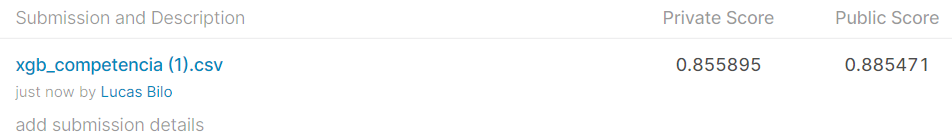

In [ ]:
cols_when_model_builds = x_train.columns.values.tolist()

x_valid = None
y_valid = None
x_train = None
y_train = None

In [ ]:
downloaded = drive.CreateFile({'id': '1ko32LSWQj9dfrhkG2XwA2MsqAdFZf6eG'})
downloaded.GetContentFile('test_identity.csv')
downloaded = drive.CreateFile({'id': '19qclUn75nu2_bh0iz9ELlYlW0dajkt9p'})
downloaded.GetContentFile('test_transaction.csv')
downloaded = drive.CreateFile({'id': '1KUkhQTM2oE52YF2x_Z_5PGXjAfM2UAG3'})
downloaded.GetContentFile('sample_submission.csv')

In [ ]:
t_identity = pd.read_csv('test_identity.csv', encoding='latin-1')
t_transaction = pd.read_csv('test_transaction.csv', encoding='latin-1')
x_test = t_transaction.merge(t_identity, left_on= 'TransactionID', right_on='TransactionID',how='outer')
t_identity = None
t_transaction = None
x_test = x_test.drop(['TransactionID'], axis = 1) 
x_test.columns = x_test.columns.str.replace('id-','id_')

Debo aplicarle los mismos encondings que hice con train:

In [ ]:
x_test.fillna(aux2, inplace=True)
x_test.fillna('Desconocido', inplace=True)

In [ ]:
x_test.loc[~x_test['DeviceInfo'].isin(device_info), 'DeviceInfo'] = 'Otros'
x_test.loc[~x_test['id_31'].isin(id_31), 'id_31'] = 'Otros'
x_test.loc[~x_test['id_33'].isin(id_33), 'id_33'] = 'Otros'

device_info = None
id_31 = None
id_33 = None

In [ ]:
ohe_test = pd.get_dummies(x_test['ProductCD'], drop_first = False, dummy_na = True)
x_test.drop(['ProductCD'], axis = 1, inplace = True)
x_test = pd.concat([x_test, ohe_test], axis = 1)

In [ ]:
voc_test = cv.transform(x_test['id_30'].tolist())
vc_test = pd.DataFrame(voc_test.todense(), columns=cv.get_feature_names_out())
vc_test.drop(voc_a_borrar, axis=1, inplace=True)
voc_test = None

x_test.drop(['id_30'], axis = 1, inplace = True)
vc_test.index = x_test.index
x_test = pd.concat([x_test, vc_test], axis = 1)

In [ ]:
for column in x_test:
  if (x_test[column].dtype == object):
    x_test[column] = x_test[column].replace(mean_encoded)

In [ ]:
submission = pd.read_csv('sample_submission.csv', encoding='latin-1')

In [ ]:
x_test = x_test[cols_when_model_builds]

pp = model.predict_proba(x_test)[:,1]
submission['isFraud'] = pp
submission.to_csv('xgb_competencia.csv', index=False)
submission.head()

,TransactionID,isFraud
0,3663549,0.021282
1,3663550,0.021876
2,3663551,0.035906
3,3663552,0.023312
4,3663553,0.035501
